In [0]:
from keras.datasets import cifar10
from keras.models import Sequential,Model,load_model,save_model
from keras.layers import Input,Dense,LeakyReLU,BatchNormalization,ReLU
from keras.layers import Conv2D,Conv2DTranspose,Reshape,Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model,np_utils
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
import os
import os.path as path
from google.colab import files
from random import sample
from keras.callbacks import TensorBoard
%matplotlib inline
import sys


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# References:
https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/
https://arxiv.org/abs/1511.06434
https://github.com/mafda/generative_adversarial_networks_101/blob/master/src/cifar10/02_DCGAN_CIFAR10.ipynb
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/


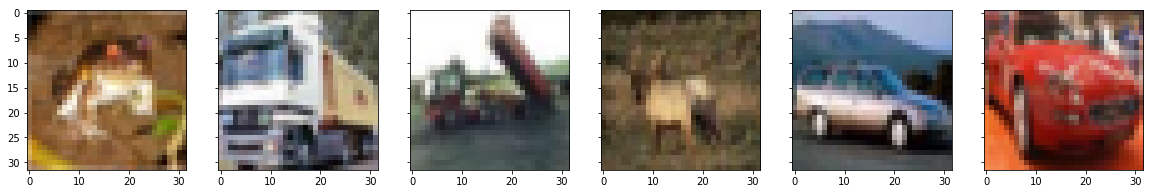

In [3]:
(X_train,Y_train),(X_test,Y_test)=cifar10.load_data()
fig,axes=plt.subplots(figsize=(20,4),nrows=1,ncols=6,sharey=True,sharex=False)
for i in range(6):
  axes[i].xaxis.set_visible=False
  axes[i].yaxis.set_visible=False
  im=axes[i].imshow(X_train[i])

In [4]:
num_classes=len(np.unique(Y_train))
classes=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
Y_train=np_utils.to_categorical(Y_train,num_classes)
Y_test=np_utils.to_categorical(Y_test,num_classes)

X_tain=np.float32(X_train)
X_train=(X_train/255-0.5)*2
X_train=np.clip(X_train,-1,1)

X_test=np.float32(X_test)
X_test=(X_test/255-0.5)*2
X_test=np.clip(X_test,-1,1)

print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [0]:
latent_dim=100
init=initializers.RandomNormal(mean=0.0,stddev=0.02)
def BuildGenerator():
  model=Sequential()
  model.add(Dense(2*2*512,input_shape=(latent_dim,),kernel_initializer=init))
  model.add(Reshape((2,2,512)))
  model.add(BatchNormalization())


  model.add(Conv2DTranspose(256,kernel_size=4,strides=2,padding='same',activation='relu'))
  model.add(BatchNormalization())


  model.add(Conv2DTranspose(128,kernel_size=4,strides=2,padding='same',activation='relu'))
  model.add(BatchNormalization())


  model.add(Conv2DTranspose(64,kernel_size=4,strides=2,padding='same',activation='relu'))
  model.add(BatchNormalization())


  model.add(Conv2DTranspose(3,kernel_size=4,strides=2,padding='same',activation='tanh'))
  model.summary()
  return model
  

In [0]:
img_shape=X_train[0].shape
def BuildDiscriminator():
  discriminator=Sequential()

  discriminator.add(Conv2D(64,kernel_size=4,strides=2,padding='same',input_shape=(img_shape),kernel_initializer=init))
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Conv2D(128,kernel_size=4,strides=2,padding='same'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Conv2D(256,kernel_size=4,strides=2,padding='same'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Conv2D(512,kernel_size=4,strides=2,padding='same'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Flatten())
  discriminator.add(Dense(1,activation='sigmoid'))

  discriminator.summary()
  return discriminator

In [7]:
generator=BuildGenerator()













Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         2097408   
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 128)         524416    
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 

In [8]:
discriinator=BuildDiscriminator()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        3136      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         524544    
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 256)        

In [9]:

path1='/content/drive/My Drive/Colab Notebooks/DCGAN_MODELS/discriminator.h5'
path2='/content/drive/My Drive/Colab Notebooks/DCGAN_MODELS/generator.h5'
path3='/content/drive/My Drive/Colab Notebooks/DCGAN_MODELS/dcgan_model.h5'

if path.exists(path2):
  generator=load_model(path2)
else:
  generator.compile(Adam(lr=0.0002,beta_1=0.5),loss='binary_crossentropy',metrics=['binary_accuracy'])
if path.exists(path1):
  discriinator=load_model(path1)
else:
  discriinator.compile(Adam(lr=0.0002,beta_1=0.5),loss='binary_crossentropy',metrics=['binary_accuracy'])

discriinator.trainable=False
z=Input(shape=(latent_dim,))
img_generator=generator(z)
decision=discriinator(img_generator)
generator_training_model=Model(inputs=z,outputs=decision)
generator_training_model.compile(Adam(lr=0.0002,beta_1=0.5),loss='binary_crossentropy',metrics=['binary_accuracy'])
generator_training_model.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         2966723   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 2762177   
Total params: 5,728,900
Trainable params: 2,964,803
Non-trainable params: 2,764,097
_________________________________________________________________


In [0]:
def get_FID_score(images1, images2,shs=1562):
  # example of calculating the frechet inception distance in Keras
  import numpy
  from numpy import cov
  from numpy import trace
  from numpy import iscomplexobj
  from numpy import asarray
  from numpy.random import randint
  from scipy.linalg import sqrtm
  from keras.applications.inception_v3 import InceptionV3
  from keras.applications.inception_v3 import preprocess_input
  from keras.datasets.mnist import load_data
  from skimage.transform import resize

  # scale an array of images to a new size
  def scale_images(images, new_shape):
    images_list = list()
    for image in images:
      # resize with nearest neighbor interpolation
      new_image = resize(image, new_shape, 0)
      # store
      images_list.append(new_image)
    return asarray(images_list)

  # calculate frechet inception distance
  def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
      covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

  # prepare the inception v3 model
  model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
  # define two fake collections of images
  # images1 = randint(0, 255, 10*32*32*3)
  images1 = images1.reshape((shs,32,32,3))
  # # images2 = randint(0, 255, 10*32*32*3)
  images2 = images2.reshape((shs,32,32,3))
  # print('Prepared', images1.shape, images2.shape)
  # convert integer to floating point values
  images1 = images1.astype('float32')
  images2 = images2.astype('float32')
  # resize images
  images1 = scale_images(images1, (299,299,3))
  images2 = scale_images(images2, (299,299,3))
  # print('Scaled', images1.shape, images2.shape)
  # pre-process images
  
  # fid between images1 and images1
  # fid = calculate_fid(model, images1, images1)
  # print('FID (same): %.3f' % fid)
  # fid between images1 and images2
  fid = calculate_fid(model, images1, images2)
  print('FID (different): %.3f' % fid)
  return fid
 
   

In [11]:

log_dir1 = '/content/drive/My Drive/Colab Notebooks/DCGAN_LOGS'

gan_fake_tensorboard = TensorBoard(
  log_dir=log_dir1,
  histogram_freq=0,
  batch_size=10,
  write_graph=True,
  write_grads=True
)
gan_fake_tensorboard.set_model(discriinator)



epoch = 1/100, d_loss=0.652, g_loss=2.881                                                                                                     



FID (different): 177.919


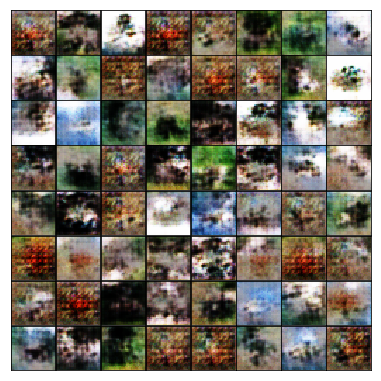

epoch = 2/100, d_loss=0.510, g_loss=2.244                                                                                                     
epoch = 3/100, d_loss=0.455, g_loss=3.697                                                                                                     
epoch = 4/100, d_loss=0.493, g_loss=4.241                                                                                                     
epoch = 5/100, d_loss=0.228, g_loss=3.699                                                                                                     
epoch = 6/100, d_loss=0.307, g_loss=3.536                                                                                                     
epoch = 7/100, d_loss=0.299, g_loss=3.183                                                                                                     
epoch = 8/100, d_loss=0.524, g_loss=3.515                                                                                                     

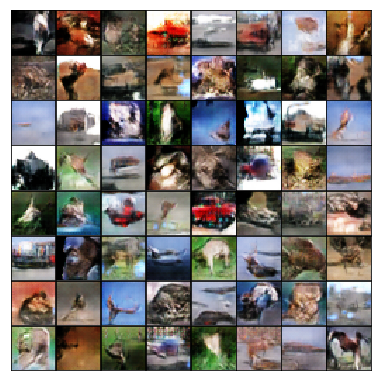

epoch = 22/100, d_loss=0.182, g_loss=6.011                                                                                                     
epoch = 23/100, d_loss=0.341, g_loss=2.052                                                                                                     
epoch = 24/100, d_loss=0.663, g_loss=6.739                                                                                                     
epoch = 25/100, d_loss=0.177, g_loss=7.076                                                                                                     
epoch = 26/100, d_loss=0.185, g_loss=5.501                                                                                                     
epoch = 27/100, d_loss=0.190, g_loss=6.812                                                                                                     
epoch = 28/100, d_loss=0.181, g_loss=4.384                                                                                              

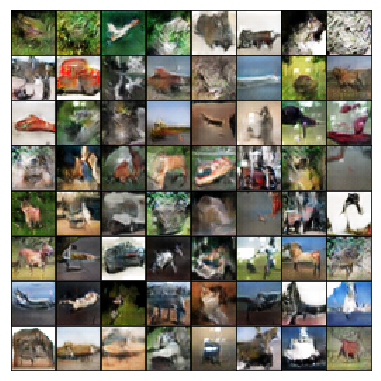

epoch = 42/100, d_loss=0.204, g_loss=4.991                                                                                                     
epoch = 43/100, d_loss=0.213, g_loss=4.488                                                                                                     
epoch = 44/100, d_loss=0.224, g_loss=3.257                                                                                                     
epoch = 45/100, d_loss=0.183, g_loss=6.072                                                                                                     
epoch = 46/100, d_loss=0.382, g_loss=3.964                                                                                                     
epoch = 47/100, d_loss=0.214, g_loss=5.317                                                                                                     
epoch = 48/100, d_loss=0.209, g_loss=5.080                                                                                              

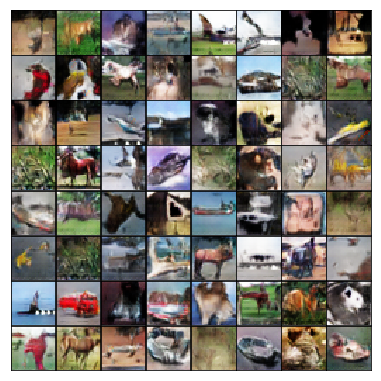

epoch = 62/100, d_loss=0.186, g_loss=5.237                                                                                                     
epoch = 63/100, d_loss=0.184, g_loss=5.181                                                                                                     
epoch = 64/100, d_loss=0.194, g_loss=3.226                                                                                                     
epoch = 65/100, d_loss=0.176, g_loss=5.534                                                                                                     
epoch = 66/100, d_loss=0.198, g_loss=5.239                                                                                                     
epoch = 67/100, d_loss=0.224, g_loss=4.348                                                                                                     
epoch = 68/100, d_loss=0.183, g_loss=5.114                                                                                              

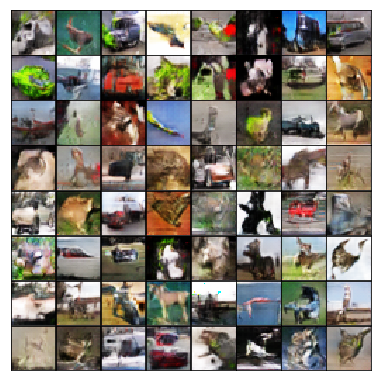

Buffered data was truncated after reaching the output size limit.

In [12]:
epochs = 100
batch_size = 32
smooth = 0.1
real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))
d_loss = []
g_loss = []
fid_score=[]
fid_sample=[]
def plot_data(x,ax):
    ax.imshow((x+1)/2, cmap='gray') 

def plot_images(x,batch_size=100):
    fig = plt.figure(figsize=(5,5))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.01, wspace=0.01)

    for i in range(batch_size):
        ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
        plot_data(x[i], ax)

fol = '/content/drive/My Drive/Colab Notebooks/DCGAN_IMAGES/'
def plotGeneratedImages(epoch, examples=64, dim=(1, 1), figsize=(2, 2)):
    n_classes = 10
    noise = np.random.normal(loc=0, scale=1, size=(64, latent_dim))
    generatedImages = generator.predict(noise)
    fig = plt.figure(figsize=(5,5))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.01, wspace=0.01)
    for i in range(examples):
        ax = fig.add_subplot(8,8, i+1, xticks=[], yticks=[])
        plot_data(generatedImages[i], ax)
    
    if not os.path.exists(fol):
        os.makedirs(fol)
    plt.savefig(fol+'random_{:05d}.png'.format(epoch))
    if(epoch%20==0):
      plt.show()
    plt.close()

miminum_fid=sys.maxsize
for e in range(epochs):
    X_fake_full=[]
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriinator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_real = discriinator.train_on_batch(x=X_batch,
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        noise = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(noise)
     
        d_fake = discriinator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_epoch = 0.5 * (d_real[0] + d_fake[0])
        
        # Train Generator weights
        discriinator.trainable = False
        g_loss_epoch = generator_training_model.train_on_batch(x=noise, y=real)

        print('epoch = %d/%d,d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs,d_loss_epoch, g_loss_epoch[0]),100*' ',end='\r')
   
  
    d_loss.append(d_loss_epoch)
    g_loss.append(g_loss_epoch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')
   
    
    gan_fake_tensorboard.on_epoch_end(e, {"D_real_loss":d_real[0] ,"D_fake_loss":d_fake[0],"GAN_loss":g_loss_epoch[0]})
    
    if e%10==0:
      noise1 = np.random.normal(loc=0, scale=1, size=(1562, latent_dim))
      X_fake1 = generator.predict_on_batch(noise1)
      fid_sc=get_FID_score(X_test[0:1562],X_fake1)
      fid_sample.append(fid_sc)
      plotGeneratedImages(e)
      if(fid_sc<miminum_fid):
        miminum_fid=fid_sc
        discriinator.trainable=False
        generator_training_model.save('/content/drive/My Drive/Colab Notebooks/DCGAN_MODELS/dcgan_model.h5')
        discriinator.trainable=True
        discriinator.save('/content/drive/My Drive/Colab Notebooks/DCGAN_MODELS/discriminator.h5')
        generator.save('/content/drive/My Drive/Colab Notebooks/DCGAN_MODELS/generator.h5')
gan_fake_tensorboard.on_train_end(None)

   


In [13]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/My\ Drive/Colab\ Notebooks/DCGAN_LOGS

Reusing TensorBoard on port 6006 (pid 3031), started 4:27:56 ago. (Use '!kill 3031' to kill it.)

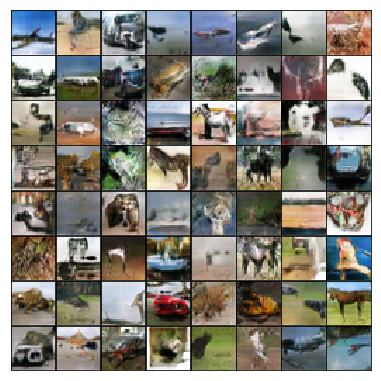

FID (different): 65.970
65.96987927376908


In [20]:
path_tosavedmodels='/content/drive/My Drive/Colab Notebooks/DCGAN_MODELS/generator.h5'
generator=load_model(path_tosavedmodels)

noise_fid = np.random.normal(loc=0, scale=1, size=(1300, latent_dim))
X_fake_fid =generator.predict_on_batch(noise_fid)
def plot_data(x,ax):
    ax.imshow((x+1)/2, cmap='gray') 
examples=64
dim=(1,1)
figsize=(2,2)
fig = plt.figure(figsize=(5,5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.01, wspace=0.01)
for i in range(examples):
  ax = fig.add_subplot(8,8, i+1, xticks=[], yticks=[])
  plot_data(X_fake_fid[i], ax)
plt.savefig('/content/drive/My Drive/Colab Notebooks/DCGAN_IMAGES/best.png')
plt.show()
plt.close()
fid_last=get_FID_score(X_test[0:1300],X_fake_fid,1300)
print(fid_last)

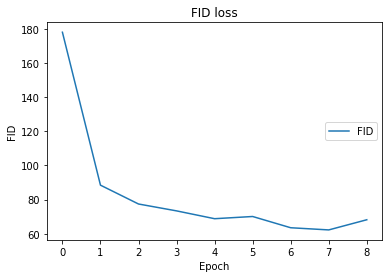

In [21]:
plt.plot(fid_sample)
plt.title('FID loss')
plt.ylabel('FID')
plt.xlabel('Epoch')
plt.legend(['FID'], loc='center right')
plt.show()